!pip install --no-cache-dir --upgrade git+https://github.com/Evfro/polara.git@develop#egg=polara  
!pip install ipypb

In [1]:
import numpy as np
import pandas as pd

from polara import get_movielens_data, RecommenderData, SVDModel
from polara.recommender.models import RandomSampleEvaluationSVDMixin
from polara.recommender.data import RandomSampleEvaluationMixin
from polara.evaluation.pipelines import find_optimal_svd_rank

try:
    from ipypb import track
except ImportError:
    from tqdm.auto import tqdm as track

The follwoing setup is based on experiment description from the RecWalk paper:  
_"RecWalk: Nearly Uncoupled Random Walks for Top-N Recommendation"_; Athanasios N. Nikolakopoulos, George Karypis; WSDM '19.  
Where necessary, quotes from the original paper are provided.

In [25]:
# randomization control
seed = 0
# sampling settings
sample_max_rated = True
rating_threshold = 0 # for ratings [1, 2, 3, 4, 5]
# evaluation setitings
target_metric = 'hr'
svd_ranks = range(5, 301, 5)

Logged results (with kernel restarts):  
```python
seed = 0

sample_max_rated = True, rating_threshold = 0:  
hr=0.5351879450240106, arhr=0.2851301855400216

sample_max_rated = False, rating_threshold = 0:  
hr=0.41903973509933773, arhr=0.1985599311468517
    
sample_max_rated = True, rating_threshold = 4:  
hr=0.4904722452361226, arhr=0.2521915808576952

sample_max_rated = False, rating_threshold = 4:  
hr=0.39459728206827976, arhr=0.1844694877177476    
```

## Data preparation

In [3]:
ml_data = (
    get_movielens_data('D:/datasets/recsys/movielens/ml-1m.zip')
    .query('rating >= @rating_threshold')
)

## train-test split

Quote:  
`...for each user we randomly select one liked item...and we create a testset T...  
...the per-user ‘liked’ item is randomly sampled among the highest rated items of each particular user...`

Quote:  
`For model selection we repeat the same procedure on the training data and we create a validation set V; and for each method considered we explore the hyperparameter space to find the modelthat yields the best performance in recommending the items in V,and then we evaluate its out-of-sample performance based on the held-out items in T`

In [4]:
def split_holdout(data, sample_max_rated=True, seed=None):
    'Randomized sampling of a highly rated item per every user in data'
    idx_grouper = (
        data
        .sample(frac=1, random_state=seed) # randomly permute data
        .groupby('userid', as_index=False, sort=False)
    )
    if sample_max_rated: # take single item with the highest score
        idx = idx_grouper.rating.idxmax()
    else: # data is already permuted - simply take the 1st element
        idx = idx_grouper.rating.head(1).index # sample random element
    
    observed = data.drop(idx.values)
    holdout = data.loc[idx.values]
    return observed, holdout

In [5]:
train_, holdout = split_holdout(ml_data, sample_max_rated=sample_max_rated, seed=seed) # testset
train, validation = split_holdout(train_, sample_max_rated=sample_max_rated, seed=seed) # validation

Quote:  
`During training of all competing methods we consider only binary feedback`

In [6]:
train['rating'] = 1 # make data for training implicit

### unseen items sampling

Quote:  
`...we consider for each user her corresponding test item along side 999 randomly sampled unseen items and we rank the 1000 item lists...`

In [7]:
def sample_unseen_items(user_group, item_pool, n, random_state):
    'Helper function to run on pandas dataframe grouper'
    seen_items = user_group.movieid.values
    candidates = np.setdiff1d(item_pool, seen_items, assume_unique=True)
    return random_state.choice(candidates, n, replace=False)

def sample_unseen_interactions(data, item_pool, n_random=999, seed=None):
    'Randomized sampling of unseen items per every user in data'
    random_state = np.random if seed is None else np.random.RandomState(seed)
    return (
        data
        .groupby('userid', sort=False)
        .apply(sample_unseen_items, item_pool, n_random, random_state)
    )

In [8]:
all_train_items = train.movieid.unique()

In [9]:
unseen_validation = sample_unseen_interactions(ml_data.query('userid in @validation.userid'), all_train_items, seed=seed)
unseen_holdout = sample_unseen_interactions(ml_data.query('userid in @holdout.userid'), all_train_items, seed=seed)

assert unseen_validation.apply(len).eq(999).all()
assert  not (train.query('userid==1').movieid.isin(unseen_validation.loc[1]).any())
assert unseen_holdout.apply(len).eq(999).all()
assert  not (train.query('userid==1').movieid.isin(unseen_holdout.loc[1]).any())

## Data Model Specification

In [10]:
class RandomSampleEvaluationData(
    RandomSampleEvaluationMixin, RecommenderData
): pass

In [11]:
data = RandomSampleEvaluationData(train, *train.columns)
print(data)

RandomSampleEvaluationData with Fields(userid='userid', itemid='movieid', feedback='rating')


In [12]:
data.prepare_training_only()

Preparing data...
Done.
There are 563206 events in the training and 0 events in the holdout.


### setting holdout and unseen interctions

In [13]:
data.set_test_data(holdout=validation, holdout_size=1)

3 unique movieid entities within 3 holdout interactions were filtered. Reason: not in the training data.
2 unique userid entities within 2 holdout interactions were filtered. Reason: not in the training data.
Done. There are 6032 events in the holdout.


In [14]:
data.set_unseen_interactions(unseen_validation)

In [15]:
data.unseen_interactions.head()

userid
0    [2175, 1356, 2241, 769, 1597, 3107, 896, 1575,...
1    [44, 2152, 1245, 533, 1864, 1034, 1020, 1809, ...
2    [1339, 3298, 2253, 1392, 2934, 872, 1587, 1251...
3    [2322, 3223, 3080, 3113, 3206, 2651, 2119, 352...
4    [1984, 2211, 930, 379, 1500, 1787, 372, 3347, ...
Name: movieid, dtype: object

## Recommender Model Specification

In [16]:
class RandomSampleEvaluationSVD(
    RandomSampleEvaluationSVDMixin, SVDModel
): pass

In [17]:
svd = RandomSampleEvaluationSVD(data)

In [18]:
svd.build()

PureSVD training time: 0.117s


In [19]:
svd.evaluate(metric_type='main')

[Relevance(hr=0.32940981432360744),
 Ranking(arhr=0.1475596422255905, mrr=0.14755964222559048)]

### grid search on validation data

In [20]:
best_svd_rank, svd_scores = find_optimal_svd_rank(
    svd,
    svd_ranks,
    target_metric,
    metric_type='main',
    return_scores=True,
    iterator=track
)

 [████████████████████████████████████████████████████████████] 60/60 [04:07<00:03, 4.12s/it]

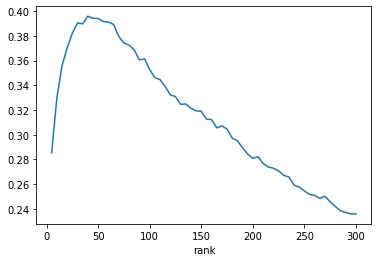

In [21]:
svd_scores.plot()

### evaluation on withheld data

In [22]:
data.set_test_data(holdout=holdout, holdout_size=1)

1 unique movieid entities within 1 holdout interactions were filtered. Reason: not in the training data.
3 unique userid entities within 3 holdout interactions were filtered. Reason: not in the training data.
Done. There are 6034 events in the holdout.


In [23]:
data.set_unseen_interactions(unseen_holdout)

In [24]:
svd.rank = best_svd_rank
svd.evaluate(metric_type='main')

[Relevance(hr=0.39459728206827976),
 Ranking(arhr=0.1844694877177476, mrr=0.18446948771774757)]